In [13]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from cs_6804_project.src.torch_cloudnet.model import CloudNet
from cs_6804_project.src.keras_cloudnet.utils import get_input_image_names
from cs_6804_project.src.keras_cloudnet.augmentation import (flipping_img_and_msk, rotate_cclk_img_and_msk,
                                                             rotate_clk_img_and_msk, zoom_img_and_msk)

In [14]:
# Paths to data
GLOBAL_PATH = "D:/38-Cloud/"
TRAIN_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_training')
TEST_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_test')

# Set params
in_rows = 192
in_cols = 192
num_of_channels = 4
num_of_classes = 1
starting_learning_rate = 1e-4
end_learning_rate = 1e-8
max_num_epochs = 2000  # just a huge number. The actual training should not be limited by this value
val_ratio = 0.2
patience = 15
decay_factor = 0.7
batch_sz = 12
max_bit = 65535  # maximum gray level in landsat 8 images
experiment_name = "Cloud-Net"
weights_path = os.path.join(GLOBAL_PATH, experiment_name + '.h5')
train_resume = False

In [15]:
# Get input/target image names
train_patches_csv_name = 'training_patches_38-cloud_nonempty.csv'
df_train_img = pd.read_csv(os.path.join(GLOBAL_PATH, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

100%|██████████████████████████████████████████████████████████████████████████| 5155/5155 [00:00<00:00, 429580.33it/s]


In [16]:
# Split data into training and validation
train_img_split, val_img_split, train_msk_split, val_msk_split = train_test_split(train_img, train_msk,
                                                                                   test_size=val_ratio,
                                                                                   random_state=42, shuffle=True)

In [17]:
class CloudDataset(Dataset):
    def __init__(self, train_files, target_files, img_rows, img_cols, max_bit, transform=True):
        self.train_files = train_files
        self.target_files = target_files
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.max_bit = max_bit
        self.transform = transform

    def __len__(self):
        return len(self.target_files)

    def __getitem__(self, idx):
        # Get input images
        image_red = imread(self.train_files[idx][0])
        image_green = imread(self.train_files[idx][1])
        image_blue = imread(self.train_files[idx][2])
        image_nir = imread(self.train_files[idx][3])
        images = np.stack((image_red, image_green, image_blue, image_nir),axis=-1).astype('int32')
        images = resize(images, (self.img_rows, self.img_cols),
                        order = 0, preserve_range=True, mode='symmetric', anti_aliasing=False)
        # Get target image
        target = imread(self.target_files[idx])
        target = resize(target, (self.img_rows, self.img_cols), 
                        order = 0, preserve_range=True, mode='symmetric', anti_aliasing=False)
        
        # Perform image augmentation
        if self.transform:
            images, target = self.transform_data(images, target)
        
        # Switch to CHW format and convert to Dataset
        #images = np.moveaxis(images, 2, 0)
        # target = target[np.newaxis, ...]
        return ToTensor()(images), ToTensor()(target)
    
    def transform_data(self, images, target):
        rnd_flip = 0
        rnd_rotate_clk = 1
        rnd_rotate_cclk = 0
        rnd_zoom = 0
        #np.random.randint(2, dtype=int)

        if rnd_flip == 1:
            images, target = flipping_img_and_msk(images, target)

        if rnd_rotate_clk == 1:
            images, target = rotate_clk_img_and_msk(images, target)

        if rnd_rotate_cclk == 1:
            images, target = rotate_cclk_img_and_msk(images, target)

        if rnd_zoom == 1:
            images, target = zoom_img_and_msk(images, target)

        target /= 255
        images /= self.max_bit
        return images, target

In [18]:
# Get datasets from file names
ds_train = CloudDataset(train_img_split, train_msk_split, in_rows, in_cols, max_bit, transform=True)
ds_val = CloudDataset(val_img_split, val_msk_split, in_rows, in_cols, max_bit)

In [19]:
imgtest123 = ds_train[0][0]

(192, 192)
(192, 192)


In [20]:
imgtest123.shape

torch.Size([4, 192, 192])

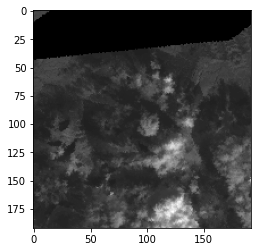

In [29]:
plt.imshow(imgtest123[3], cmap="gray")

In [22]:
msktest123 = ds_train[0][1]

(192, 192)
(192, 192)


In [23]:
msktest123.shape

torch.Size([1, 192, 192])

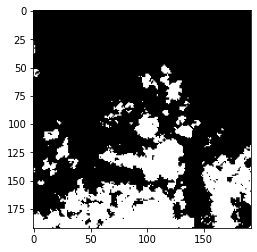

In [24]:
plt.imshow(msktest123[0], cmap="gray")

In [25]:
np.unique(msktest123)

array([0., 1.])

In [197]:
target123 = imread(train_msk[0])
red123 = imread(train_img[0][0])
green123 = imread(train_img[0][1])
blue123 = imread(train_img[0][2])
nir123 = imread(train_img[0][3])